# PLANETARY MOTION DATA SET #

## IMPORT MODULES ##

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as sm
import math
from pandas.stats.api import ols
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
import sklearn.model_selection as m_sel
import plotly.offline as plot
import plotly.graph_objs as go
from sklearn import preprocessing
from sklearn.utils import shuffle
import statsmodels.stats.diagnostic as sms
plot.offline.init_notebook_mode(connected = True)

## LOAD DATA ##

In [35]:
kepler = pd.read_csv('Ex01_Kepler_Regression.csv')
kepler = shuffle(kepler)
kepler.dropna(axis = 0, inplace = True)
kepler.drop('planet',axis = 1,inplace = True)

## CORRELATION MATRIX ##

In [3]:
correlation_matrix = kepler.corr()
correlation_matrix

,SemiMajorAxis,Volume,EscapeVelocity,Density,OrbitalPeriod
SemiMajorAxis,1.000000,0.278926,0.323329,-0.716234,0.918149
Volume,0.278926,1.000000,-0.015625,-0.153851,0.229391
EscapeVelocity,0.323329,-0.015625,1.000000,-0.687354,0.225476
Density,-0.716234,-0.153851,-0.687354,1.000000,-0.565611
OrbitalPeriod,0.918149,0.229391,0.225476,-0.565611,1.000000


## CORRELATION GRAPH ##

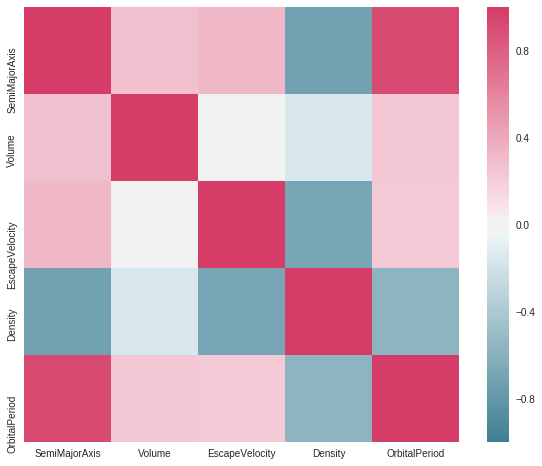

In [5]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            mask = np.zeros_like(correlation_matrix, dtype = np.bool), 
            cmap = sns.diverging_palette(220, 1, as_cmap = True),
            square = True,
            ax = ax)
plt.show()

## SCATTER GRAPH ##

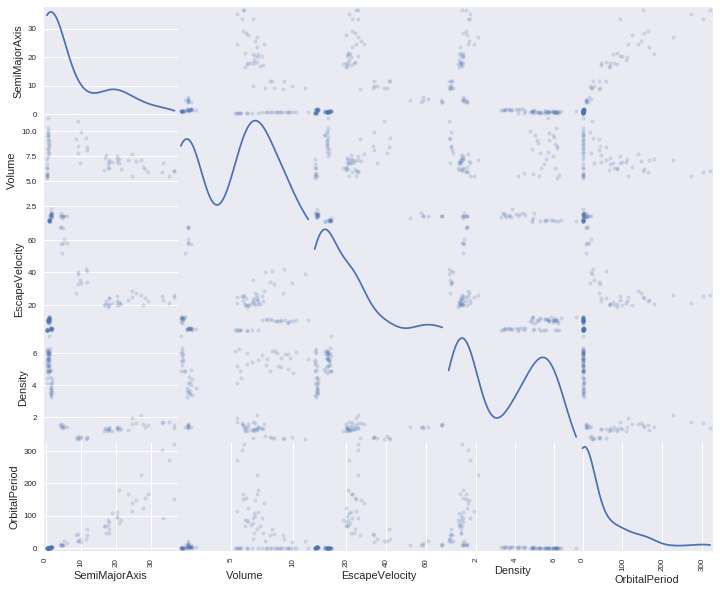

In [6]:
pd.scatter_matrix(kepler, alpha = .2, figsize = (12, 10), diagonal = 'kde')
plt.show()

## NORMALIZING DATA ##

In [7]:
data_norm = kepler
for i in data_norm.columns.tolist():
    data_norm[i] = (data_norm[i] - data_norm[i].mean()) / (data_norm[i].var())

## SPLITTING TRAINING AND TESTING DATA ##

In [8]:
X_rl = pd.get_dummies(data_norm).drop('OrbitalPeriod', axis = 1)
y_rl = data_norm.OrbitalPeriod
X_train, X_test , Y_train, Y_test = m_sel.train_test_split(X_rl, y_rl, test_size = 0.20, random_state = 20)

## LINEAR REGRESSION MODEL ##

In [9]:
reg = linear_model.LinearRegression(normalize = True)
reg.fit(X_train, Y_train)
print ('Coefficients : ', reg.coef_) 
print ('\nIntercepts  : ', reg.intercept_)
print ('\nRoot Mean Square Error : ', math.sqrt(np.mean((reg.predict(X_test) - Y_test) ** 2)))

Coefficients :  [ 0.16937683 -0.00208937  0.00919827  0.00730283]

Intercepts  :  6.25379837095e-05

Root Mean Square Error :  0.004137229198827117


## REGRESSION MODEL PLOT ##

In [10]:
trace1 = go.Scatter(
    x = reg.predict(X_test),
    y = Y_test,
    mode ='markers',
    name = 'Predicted vs Original',
    line = dict(shape = 'linear')
)
trace2 = go.Scatter(
    x = Y_test,
    y = Y_test,
    mode = 'lines',
    name = 'x = y',
    line = dict(shape = 'linear')
)
data = [trace1, trace2]
layout = dict(
    title = 'SCATTER PLOT FOR REGRESSION MODEL',
    xaxis = dict(
        title = 'PREDICTED VALUE '
    ),
    yaxis = dict(
        title = 'ORIGINAL VALUE'
    ),
    legend = dict(
        traceorder = 'reversed',
        font = dict(size = 16)
    )
)
fig = dict(data = data, layout = layout)
plot.iplot(fig, filename='PLANETARY_Regression Model')


## BOX PLOT FOR REGRESSION ##

In [11]:
trace1 = go.Box(
    y = (reg.predict(X_test) - Y_test)
)
data = [trace1]
plot.iplot(data)

## RIDGE REGRESSION ##

In [17]:
alphas_ridge = 10 ** np.linspace(-3, 3, 100)

ridge = linear_model.Ridge(normalize = True)
coefs = []
for a in alphas_ridge:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, Y_train)
    coefs.append(ridge.coef_)


coefs = np.array(coefs)
df_ridge = (pd.DataFrame(coefs, columns = X_train.columns, index = alphas_ridge))


## WEIGHT VS ALPHA ##

In [20]:
data = []
for r in range(len(X_train.columns)):
    trace = go.Scatter(
        x = alphas_ridge,
        y = coefs[:, r],
        mode = 'lines+markers',
        name = X_train.columns[r],
        line = dict(shape = 'linear')
    )
    data.append(trace)
layout = dict(
    title='WEIGHTS VS ALPHAS',
    yaxis = dict(
        range = [-3,3],
        title='WEIGHT'
    ),
    xaxis = dict(
        range = [0,1],
        title='ALPHAS'
    ),
    legend = dict(
        traceorder = 'reversed',
        font = dict(size = 16)
    ))

fig = dict(data = data, layout = layout)
plot.iplot(fig, filename = 'WEIGHTS_VS_ALPHAS_PLANETARY')

## MEAN ERROR VS ALPHA ##

In [21]:
data = []
p = go.Scatter(x = alphas_ridge,
               y = mean_squared_error(Y_test, ridge.predict(X_test)), 
               mode = 'lines+markers',
               name = 'Mean Error',
               hoverinfo = 'name',
               line = dict(shape = 'linear'))
data.append(p)        
layout = dict(
    title = 'MEAN SQUARE ERRORS VS ALPHAS',
    xaxis = dict(
        title = 'ALPHAS'
    ),
    yaxis = dict(
        title = 'MEAN SQUARE ERRORS'
    ),
    legend = dict(
        traceorder = 'reversed',
        font = dict(size = 16)
    )
)
fig = dict(data = data, layout = layout)
plot.iplot(fig, filename = 'MEANERROR_VS_APLHA_PLANETARY')

## LASSO ##

In [22]:
alphas_lasso = np.linspace(2, -2, 100) * 0.5 
lasso = linear_model.Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas_lasso:
    lasso.set_params(alpha = a)
    lasso.fit(X_train, Y_train)
    coefs.append(lasso.coef_)


coefs = np.array(coefs)
df_lasso = (pd.DataFrame(coefs, columns = X_train.columns, index = alphas_lasso))

/home/user/test/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/user/test/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/user/test/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/user/test/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very sma

## WEIGHT VS ALPHA ##

In [23]:
data = []
for r in range(len(X_train.columns)):
    trace = go.Scatter(
        x = alphas_lasso,
        y = coefs[:, r],
        mode = 'lines+markers',
        name = X_train.columns[r],
        line = dict(shape = 'linear')
    )
    data.append(trace)
layout = dict(
    title = 'WEIGHTS VS ALPHAS',
    yaxis = dict(
        range = [-3,3],
        title = 'WEIGHT'
    ),
    xaxis = dict(
        range = [0,0.1],
        title = 'ALPHAS'
    ),
    legend = dict(
        traceorder = 'reversed',
        font = dict(size = 16)
    ))

fig = dict(data = data, layout = layout)
plot.iplot(fig, filename = 'WEIGHT_VS_ALPHA_SONAR')

## LASSO CV ##

In [28]:
lassocv = linear_model.LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, Y_train)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)
mean_squared_error(Y_test, lasso.predict(X_test)) 

1.6987300714569672e-05

In [29]:
pd.Series(lasso.coef_, index=X_test.columns)

SemiMajorAxis     0.168655
Volume           -0.002046
EscapeVelocity    0.008211
Density           0.007092
dtype: float64

## OLS REGRESSION ##

In [30]:
ols_result = sm.ols(formula="OrbitalPeriod ~ SemiMajorAxis + Volume + Density", data = data_norm.iloc[:math.floor(len(data_norm)*0.70),:]).fit()
ols_result.params
predict_ols = ols_result.predict(X_test)
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          OrbitalPeriod   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     109.2
Date:                Sun, 02 Apr 2017   Prob (F-statistic):           1.55e-25
Time:                        19:08:57   Log-Likelihood:                 265.52
No. Observations:                  70   AIC:                            -523.0
Df Residuals:                      66   BIC:                            -514.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0002      0.001     -0.357      0.722      -0.002       0.001
SemiMajorAxis     0.1429      0.011     13.375      0.000       0.122       0.164
Volume           -0.0003      0.002     -0.117      0.907      -0.005       0.004
Density           0.0034      0.002      1.684      0.097      -0.001       0.007
==============================================================================
Omnibus:                       41.568   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.286
Skew:                           1.456   Prob(JB):                     1.11e-57
Kurtosis:                      12.025   Cond. No.                         16.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## SCATTER PLOT FOR OLS ##

In [31]:
trace1 = go.Scatter(
    x = predict_ols,
    y =  Y_test,
    mode = 'markers',
    name = 'PREDICTED VS ORIGINAL',
    line = dict(shape = 'linear')
)
trace2 = go.Scatter(
    x = Y_test,
    y = Y_test,
    mode ='lines',
    name = 'x = y',
    line = dict(shape = 'linear')
)
data = [trace1, trace2]
layout = dict(
    title='PREDICTED VS ORIGINAL',
    yaxis = dict(
        title='PREDICTED VALUE'
    ),
    xaxis = dict(
        title = 'ORIGINAL VALUE'
    ),
    legend = dict(
        traceorder = 'reversed',
        font = dict(size = 16)
    )
)
fig = dict(data = data, layout = layout)
plot.iplot(fig, filename = 'SCATTER PLOT FOR OLS')


## HISTOGRAM FOR OLS ##

In [32]:
data = [go.Histogram(x = ((predict_ols - Y_test)))]
layout = go.Layout(
    title = 'FREQUENCY OF RESIDUALS',
    xaxis = dict(
        title = 'RESIDUALS'
    ),
    yaxis = dict(
        title = 'FREQUENCY'
    )
)
fig = go.Figure(data = data, layout = layout)
plot.iplot(fig, filename = 'OLS_HISTOGRAM_PLANETARY')

## BOX PLOT FOR OLS ##

In [33]:
trace1 = go.Box(
    y = (predict_ols - Y_test)
)
data = [trace1]
plot.iplot(data)

## Goldfeld Quandt Test ##

In [34]:
name = ['F statistics', 'p_value']
test = sms.het_goldfeldquandt(ols_result.resid, ols_result.model.exog)
list(zip(name, test))

[('F statistics', 0.9744106594372095), ('p_value', 0.5285337107903425)]